# Лабораторная работа № 4
## Сети с радиальными базисными элементами

`Цель работы:` исследование свойств некоторых видов сетей с радиальными базисными элементами, алгоритмов обучения, а также применение сетей в задачах классификации и аппроксимации функции.

|Студент| Мариничев И.А.|
|-|-|
|**Группа**| **М8О-408Б-19**|
|**Вариант**| **5**|

Импортируем всё нобходимое

In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

Определим три группы точек (эллипсы с поворотом), соответствующие трем классам

In [2]:
def ellipse(t, a, b, x0, y0):
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    return x, y

In [3]:
def rotate(x, y, alpha):
    xr = x * np.cos(alpha) - y * np.sin(alpha)
    yr = x * np.sin(alpha) + y * np.cos(alpha)
    return xr, yr

In [4]:
t = np.linspace(0, 2 * np.pi, 200)

In [5]:
# Эллипс: a = 0.4, b = 0.15, α = π/6, x0 = −0.1, y0 = 0.15
x1, y1 = ellipse(t, a=0.4, b=0.15, x0=-0.1, y0=0.15)
x1, y1 = rotate(x1, y1, np.pi / 6.)

In [6]:
# Эллипс: a = 0.7, b = 0.5, α = −π/3, x0 = 0, y0 = 0
x2, y2 = ellipse(t, a=0.7, b=0.5, x0=0., y0=0.)
x2, y2 = rotate(x2, y2, -np.pi / 3.)

In [7]:
# Эллипс: a = 1, b = 1, α = 0, x0 = 0, y0 = 0
x3, y3 = ellipse(t, a=1., b=1., x0=0., y0=0.)
x3, y3 = rotate(x3, y3, 0.)

In [8]:
points1 = [[x, y] for x, y in zip(x1, y1)]
points2 = [[x, y] for x, y in zip(x2, y2)]
points3 = [[x, y] for x, y in zip(x3, y3)]

classes1 = [[1., 0., 0.] for _ in range(len(points1))]
classes2 = [[0., 1., 0.] for _ in range(len(points2))]
classes3 = [[0., 0., 1.] for _ in range(len(points3))]

X = points1 + points2 + points3
y = classes1 + classes2 + classes3

И разделим данные на тренировочные и тестовые

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
x_train = torch.FloatTensor(np.array(x_train))
y_train = torch.FloatTensor(np.array(y_train))

x_test = torch.FloatTensor(np.array(x_test))
y_test = torch.FloatTensor(np.array(y_test))

Будем обучать нашу сеть батчами размера `batch_size`, так как данных уже довольно много

In [11]:
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

batch_size = int(len(train_dataset) * 0.1)
train_loader = DataLoader(train_dataset, batch_size)

Создадим класс слоя радиально-базисной функции (РБФ)

In [12]:
# норма
def l_norm(x, p=2):
    return torch.norm(x, p=p, dim=-1)

# радиально-базисная функция (мультиквадратичная)
def rbf_multiquadric(x):
    return (1 + x.pow(2)).sqrt()

In [13]:
class RBFLayer(nn.Module):
    def __init__(self, in_features: int, num_kernels: int, out_features: int):
        super(RBFLayer, self).__init__()
        self.in_features = in_features
        self.num_kernels = num_kernels 
        self.out_features = out_features
        self._make_parameters()

    def _make_parameters(self):
        self.weights = nn.Parameter(torch.zeros(self.out_features, self.num_kernels, dtype=torch.float32))
        self.kernels_centers = nn.Parameter(torch.zeros(self.num_kernels, self.in_features, dtype=torch.float32))
        self.log_shapes = nn.Parameter(torch.zeros(self.num_kernels, dtype=torch.float32))
        self.reset()

    def reset(self, upper_bound_kernels: float = 1.0, std_shapes: float = 0.1, gain_weights: float = 1.0):
        nn.init.uniform_(self.kernels_centers, a=-upper_bound_kernels, b=upper_bound_kernels)
        nn.init.normal_(self.log_shapes, mean=0.0, std=std_shapes)
        nn.init.xavier_uniform_(self.weights, gain=gain_weights)

    def forward(self, input: torch.Tensor):
        batch_size = input.size(0)

        # рассчитывам расстояния до центров
        mu = self.kernels_centers.expand(batch_size, self.num_kernels, self.in_features)
        diff = input.view(batch_size, 1, self.in_features) - mu

        # применяем нормировочную функцию
        r = l_norm(diff)

        # применяем параметр формы
        eps_r = self.log_shapes.exp().expand(batch_size, self.num_kernels) * r

        # применяем радиально-базисную функцию
        rbfs = rbf_multiquadric(eps_r)

        # в качестве ответа даем линейную комбинацию
        out = self.weights.expand(batch_size, self.out_features, self.num_kernels) * rbfs.view(batch_size, 1, self.num_kernels)

        return out.sum(dim=-1)

    @property
    def get_kernels_centers(self):
        return self.kernels_centers.detach()

    @property
    def get_weights(self):
        return self.weights.detach()

    @property
    def get_shapes(self):
        return self.log_shapes.detach().exp()

Наша сеть будет принимать на вход два признака, координаты (x, y), а на выходе будет выдавать три значения в диапазоне `[0, 1]`, чтобы их можно было интерпретировать как цветовую компоненту RGB. 

В качестве функции потерь берем `nn.MSELoss()`

In [14]:
rbf_net_classifier = RBFLayer(2, 10, 3)
loss_function = nn.MSELoss()
# optimizer = torch.optim.SGD(multilayer_net.parameters(), lr=0.05)
optimizer = torch.optim.Adam(rbf_net_classifier.parameters())

Определим функцию обучения на батчах

In [15]:
def fit(model, train_loader, criterion, optimizer, epochs):
    losses = []

    running_loss = 0.0
    processed_data = 0

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outp = model(inputs)

                loss = criterion(outp, labels)

                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                processed_data += inputs.size(0)

            train_loss = running_loss / processed_data
            losses.append(train_loss)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=loss))
    return losses

А также определим функцию предсказания

In [16]:
def predict(model, x_test):
    with torch.no_grad():
        model.eval()
        outp = model(x_test)
    return outp

Обучим модель

In [ ]:
losses = fit(rbf_net_classifier, train_loader, loss_function, optimizer, 2500)

Посмотрим на график функции потерь, вычисляющей `MSE` между исходными и полученными данными

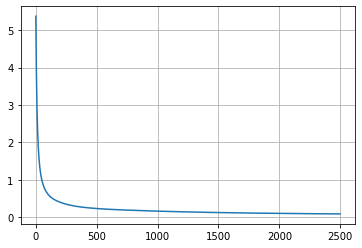

In [18]:
plt.plot(losses)
plt.grid(True, which='both')
plt.show()

Теперь соберем предсказания модели для каждой точки области `[-1, 1] x [-1, 1]`

In [19]:
x_test = [[x, y] for x in np.linspace(-1, 1, 200) for y in np.linspace(-1, 1, 200)]

x_test = torch.FloatTensor(np.array(x_test))

predicted_RGB = predict(rbf_net_classifier, x_test)
predicted_RGB = predicted_RGB.reshape((200, 200, 3))

Теперь построим наши три класса

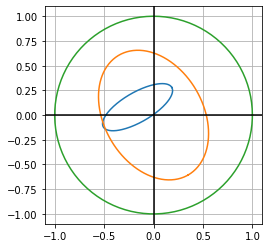

In [20]:
plt.plot(x1, y1)
plt.plot(x2, y2)
plt.plot(x3, y3)
plt.gca().set_aspect(1)

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.show()

И посмотрим на цветовое представление того, как наша сеть справилась с разделением области на три класса, которые линейно неразделимы

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


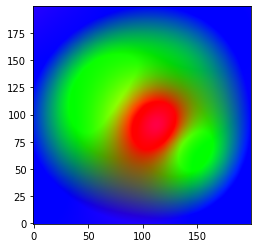

In [22]:
plt.imshow(predicted_RGB)
plt.gca().invert_yaxis()

plt.show()

Теперь перейдем к задаче аппроксимации функции. Создадим разреженную дискретную версию нашей исходной функции и будем использовать ее для обучения, чтобы потом получить при увеличенни шага приближение исходной функции

In [23]:
def function(t):
    return np.cos(-3 * t**2 + 5 * t + 10)

In [24]:
t1 = np.linspace(0, 2.5, 150)
f1 = function(t1)

t2 = np.linspace(0, 2.5, 2000)
f2 = function(t2)

In [25]:
x_train2 = torch.FloatTensor(t1)
y_train2 = torch.FloatTensor(f1)

x_train2 = x_train2.view(-1, 1)
y_train2 = y_train2.view(-1, 1)
train_dataset2 = TensorDataset(x_train2, y_train2)

x_test2 = torch.FloatTensor(t2)
x_test2 = x_test2.view(-1, 1)

Наша сеть будет принимать на вход один признак, координату x, а на выходе будет выдавать значение функции в этой точке. 

В качестве функции потерь берем `nn.MSELoss()`

In [26]:
rbf_net_approximator = RBFLayer(1, 35, 1)
loss_function = nn.MSELoss()
# optimizer = torch.optim.SGD(multilayer_net.parameters(), lr=0.05)
optimizer = torch.optim.Adam(rbf_net_approximator.parameters())

Будем обучать нашу сеть батчами размера `batch_size`, так как данных уже довольно много

In [27]:
batch_size = 10
train_loader2 = DataLoader(train_dataset2, batch_size)

Обучим модель

In [ ]:
losses2 = fit(rbf_net_approximator, train_loader2, loss_function, optimizer, 2500)

Посмотрим на график функции потерь, вычисляющей `MSE` между исходными и полученными данными

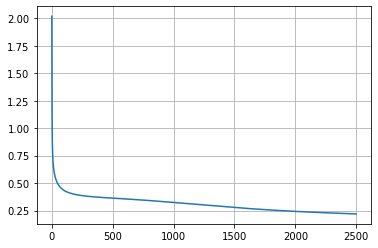

In [29]:
plt.plot(losses2)
plt.grid(True, which='both')
plt.show()

Cоберем предсказания модели

In [30]:
f2_pred = predict(rbf_net_approximator, x_test2)

И предсказания в центрах РБФ

In [31]:
mu_x = rbf_net_approximator.get_kernels_centers
mu_y = predict(rbf_net_approximator, mu_x)

Теперь визуализируем полученные результаты и сравним приближение, разреженный вариант и истинную функцию 

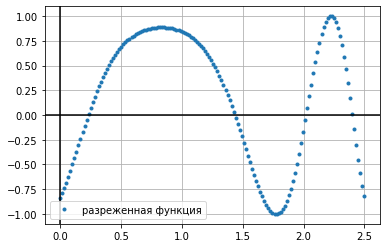

In [32]:
plt.plot(t1, f1, '.', label='разреженная функция')

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.legend()
plt.show()

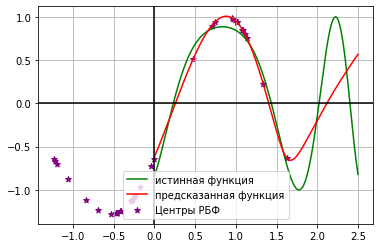

In [33]:
plt.plot(t2, f2, color="green", label='истинная функция')
plt.plot(t2, f2_pred, color="red", label='предсказанная функция')
plt.scatter(mu_x, mu_y, color="purple", marker='*', label='Центры РБФ')

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.legend()
plt.show()

`Выводы:` в ходе данной работы была построена сеть основанная на радиально-базисной функции, которая была использована для решения двух типов задач:
- классификация (линейно неразделимые данные)
- аппроксимация

После обучения (`2500` эпох) были получены довольно неплохие результаты